## Hackaton-Good-Fast-Cheap

## This is a Group Project with the following members:
### - Eileen Palmer
### - Jurgen Arias
### - Larry Curran
### - Djuwita Carney

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score

%matplotlib inline


import warnings
warnings.filterwarnings('ignore')

In [2]:
## Read Data

df = pd.read_csv('./data/large_train_sample.csv')

In [3]:
df.shape

(32561, 14)

In [4]:
## Check missing data

df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

In [5]:
## Drop 'education' column since it is also represented by 'education-num' column

df.drop(['education','fnlwgt'], inplace = True, axis = 1)

In [6]:
## Similarly, for occupations, one column was created using index from 1 to 12

df['occupation']= df.occupation.map({
     ' ?': 5,                    #0.275439
    ' Adm-clerical': 8,         #0.333810
    ' Armed-Forces': 4,          #0.200000
    ' Craft-repair': 10,             #0.472984
     ' Exec-managerial': 15,         #0.746158
     ' Farming-fishing' : 6,         #0.296800
     ' Handlers-cleaners': 3,        #0.179553
     ' Machine-op-inspct': 7,        #0.314822
     ' Other-service': 2,            #0.119844
     ' Priv-house-serv': 1,          #0.013333
     ' Prof-specialty': 14,           #0.717243
     ' Protective-serv': 13,         #0.609277
     ' Sales': 11,                   #0.542067
     ' Tech-support': 12,            #0.584942
     ' Transport-moving': 9          #0.443815
})

In [7]:
## Check the unbalanceness of the data

df['wage'].value_counts(normalize=True)

 <=50K    0.75919
 >50K     0.24081
Name: wage, dtype: float64

In [8]:
## Binarize 'wage'

df['wage'] = df['wage'].map({' <=50K' : 0, ' >50K' : 1})

In [9]:
# Bootstrapping to balance the data

np.random.seed(123)
high = df[df['wage'] == 1]
new_data = high.sample(n=16_879, replace=True)
df = pd.concat([df, new_data], axis=0)
df['wage'].value_counts()

1    24720
0    24720
Name: wage, dtype: int64

In [10]:
# Reindexing

df = df.reset_index(drop=True)

<Figure size 720x1440 with 0 Axes>

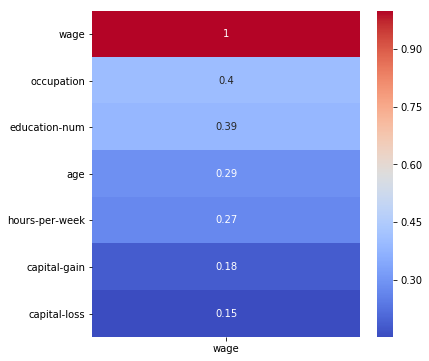

In [11]:
## Ploy Correlation Coefficients

import seaborn as sns
plt.figure(figsize = (10,20))
plt.figure(figsize=(6,6))
sns.heatmap(df.corr().abs()[['wage']].sort_values(by=['wage'],ascending=False), annot = True, cmap='coolwarm');

In [12]:
## Create dummies for classification variables

df = pd.get_dummies(df, drop_first = True)

### Feature Engineering

In [13]:
## Create Polynomial Features to improve the model scores


poly = PolynomialFeatures(degree=2, include_bias=False)
P0 = df[['marital-status_ Married-civ-spouse', 'marital-status_ Never-married']]
features = list(P0.columns)
P_poly = poly.fit_transform(P0)
P1 = pd.DataFrame(P_poly, columns=poly.get_feature_names(features))
P = P0.merge(P1, left_index=True, right_index=True)
P.drop(columns=['marital-status_ Married-civ-spouse_x', 'marital-status_ Married-civ-spouse_y',
                'marital-status_ Never-married_x', 'marital-status_ Never-married_y'], inplace=True)

df = P.merge(df, left_index=True, right_index=True)

poly = PolynomialFeatures(degree=2, include_bias=False)
P0 = df[['age', 'education-num']]
features = list(P0.columns)
P_poly = poly.fit_transform(P0)
P1 = pd.DataFrame(P_poly, columns=poly.get_feature_names(features))
P = P0.merge(P1, left_index=True, right_index=True)
P.drop(columns=['age_y', 'education-num_y', 'age_x', 'education-num_x'], inplace=True)

df = P.merge(df, left_index=True, right_index=True)

In [14]:
#### Create a correlation coefficien heatmap to deermined the varianles that have strongest correlation with 'wage'

In [15]:
## Get features from all variables

X = df.drop('wage', axis=1)
y = df['wage']

In [16]:
## Scaling

ss= StandardScaler()
X_sc = ss.fit_transform(X)

In [17]:
## Transform X_sc array to DataFrame

X_sc = pd.DataFrame(X_sc, columns=X.columns)

In [18]:
# Split Train and Test data

X_train, X_test, y_train, y_test = train_test_split(X_sc,y,stratify = y, random_state = 42)

### Determine the 20 best features by performing Logistic regression using all available features and sorting the absolute values of the coefficients

In [19]:
from sklearn.model_selection import cross_val_score


lr = LogisticRegression(C=1e9)
lr.fit(X_sc, y)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
## Generate and sort the regression coefficients

coefs_df = pd.DataFrame(X_sc.columns)
coefs_df.columns = ['feature']
coefs_df['coef'] = list(lr.coef_[0])

coefs_df['coefs_abs'] = abs(coefs_df['coef'])
coefs_df.sort_values(by='coefs_abs', ascending=False).head(20)


,feature,coef,coefs_abs
9,capital-gain,3.263907,3.263907
6,age,3.108763,3.108763
0,age^2,-2.552811,2.552811
21,marital-status_ Married-civ-spouse,0.612484,0.612484
3,marital-status_ Married-civ-spouse^2,0.612484,0.612484
8,occupation,0.523538,0.523538
7,education-num,0.520848,0.520848
31,sex_ Male,0.419417,0.419417
30,relationship_ Wife,0.382095,0.382095
11,hours-per-week,0.335911,0.335911


In [21]:
features = list(coefs_df.sort_values(by='coefs_abs', ascending=False).head(20)['feature'])


In [22]:
cross_val_score(lr,X,y, cv = 3)

array([0.81444175, 0.81966019, 0.81286408])

### Logistic Regression

In [23]:
X = df[features]
y = df['wage']

In [24]:
## Splitting data to train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [25]:
## Logistic linear modeling

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score


lr = LogisticRegression(C=1e9)
lr.fit(X_train, y_train)

LogisticRegression(C=1000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
lr.score(X_train, y_train)

0.818311758360302

In [27]:
lr.score(X_test, y_test)

0.8189320388349515

In [28]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [29]:
rf = RandomForestClassifier()

In [30]:
et = ExtraTreesClassifier()

## Grid Search for RandomForestClassifier
---


In [31]:
rf_params = {
    'n_estimators': [10, 50, 100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
}



gs_rf = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

0.8931499460625674


{'max_depth': None, 'n_estimators': 150}

In [ ]:
gs_rf.score(X_train, y_train)

In [ ]:
gs_rf.score(X_test, y_test)

#### Calculate RMSE

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
## For FandomForest Model


rmse= sqrt(mean_squared_error(y_test, y_hat))
rmse

### SVM Model

In [ ]:
# # Instantiate SVM.
# from sklearn.svm import SVC
# #Setting a pipeline
# pipe = Pipeline([
#     ('ss', StandardScaler()),
#     ('svc', SVC()) 
# ])
# # Hyperparameters
# svc_params = {
#     'svc__kernel': ['poly', 'rbf', 'sigmoid'],
#     'svc__C' : [.1, 1, 100],
#     'svc__gamma': [0.1, 1, 100],
# #     'svc__degrees': [0, 1, 2, 3, 4, 5, 6]
# }
# # Gridsearching
# pipe_gs = GridSearchCV(pipe, svc_params, cv=3)
# pipe_gs.fit(X_train, y_train)
# printpipe_gs.best_score_

### Gradient Boosting

In [ ]:
# GRADIENT BOOSTING

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42)

# Instantiate pipeline
pipe = Pipeline([
    ('gbc', GradientBoostingClassifier(random_state=42))
])

# Set up parameters
pipe_params = {
    'gbc__n_estimators' : [50, 100],
    'gbc__learning_rate' : [0.1, 0.5],
    'gbc__max_depth': [1, 2, 3, 4]
    
}

# Instantiate GridSearch
gs = GridSearchCV(pipe, pipe_params, cv=3)

# Fit models
gs.fit(X_train, y_train)

print(gs.best_score_)
print(gs.best_params_)

# Save best model
gbc = gs.best_estimator_

print(gbc.score(X_train, y_train))
print(gbc.score(X_test, y_test))

